In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm

from scipy import stats  # will use scipy.stats.mode as the reducer
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


In [2]:
def cluster_variance(n, x):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2).fit(x)
        kmeans.append(model)
        variances.append(model.inertia_)
    return variances,K,n

In [6]:
ds = xr.open_dataset(f"challenge_1min_numerical_EP.nc")

# ds = ds.where((ds.latitude > 0) & (ds.latitude < 20) & (ds.longitude > 100) & (ds.longitude < 160), drop=True)  # bbox = [100, -15, 160, 30],
ds = ds.where((ds.latitude > 0) & (ds.latitude < 20) & (ds.longitude > -160) & (ds.longitude < 100), drop=True)  # bbox = [-160, -10,-100, 20],


sh: 1: getfattr: not found


In [7]:
x = ds.drop_vars(['latitude','longitude']).to_array().transpose("time", "variable").values
# x = ds.to_array().transpose("time", "variable").values

x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
x

array([[0.00000000e+00, 7.23160944e-06, 1.19200074e-01, 7.78431978e-02],
       [0.00000000e+00, 3.87684227e-03, 1.99288558e-01, 1.61866720e-02],
       [0.00000000e+00, 3.81111972e-05, 1.24708356e-01, 5.72241542e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.53601588e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.30546898e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(1572, 4))

Initialization complete
Iteration 0, inertia 110.04503904065781.
Iteration 1, inertia 103.42851490429855.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 92.88666056164011.
Iteration 1, inertia 86.79580059098625.
Iteration 2, inertia 86.79098268172973.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 66.40808586273903.
Iteration 1, inertia 54.257387224188506.
Iteration 2, inertia 52.560149251001135.
Iteration 3, inertia 52.27612065713877.
Iteration 4, inertia 52.20258671442632.
Iteration 5, inertia 52.190510287161906.
Iteration 6, inertia 52.1849898896016.
Iteration 7, inertia 52.183738210759216.
Converged at iteration 7: center shift 7.253086925196194e-07 within tolerance 1.644855516925865e-06.
Initialization complete
Iteration 0, inertia 53.58560067063161.
Iteration 1, inertia 42.10579149122249.
Iteration 2, inertia 40.25622570327571.
Iteration 3, inertia 39.83302428367612.
Iteration 4, inertia 39.76

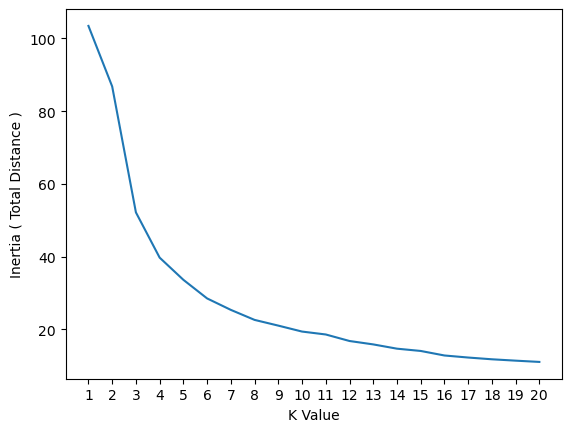

In [8]:
variances,K,n=cluster_variance(20, x)
plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

In [9]:
ds

<xarray.Dataset> Size: 69kB
Dimensions:                          (time: 1572)
Coordinates:
  * time                             (time) datetime64[ns] 13kB 2025-06-12T09...
Data variables:
    latitude                         (time) float64 13kB 3.268 7.154 ... 1.683
    longitude                        (time) float64 13kB -111.1 ... -147.1
    land_flag                        (time) float64 13kB 0.0 0.0 0.0 ... 0.0 0.0
    ice_water_path                   (time) float32 6kB 1.36e-05 ... 0.0
    liquid_water_path                (time) float32 6kB 0.04835 0.08083 ... 0.0
    aerosol_optical_thickness_355nm  (time) float32 6kB 0.2941 0.06116 ... 0.0

In [10]:
k = 5

# Applichiamo K-Means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(x)


In [11]:
vars = {
    # 'lat': 0,
    # 'lon': 1,
    'landf' : 0 ,
    'iwp': 1,
    'lwp': 2,
    'aot': 3
}

In [12]:
def plot_kmeans(x, varX, varY, ax=None):

    if not ax:
        fig, ax = plt.subplots()
    
    # Visualizziamo i dati colorati in base ai cluster trovati
    ax.scatter(x[:, vars[varX]], x[:, vars[varY]], c=y_kmeans, s=10, cmap='jet', alpha=0.5)  #'viridis')
    
    # Mostriamo anche i centroidi
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, vars[varX]], centers[:,  vars[varY]], c='red', s=50, alpha=0.75, marker='X', label='Centroids')
    for i in np.arange(1,6):
        ax.text(centers[(i-1), vars[varX]]*1.1, centers[(i-1),  vars[varY]]*1.1, s=str(i), c='red')
    
    ax.set_title("K-Means clustering")
    ax.set_xlabel(varX)
    ax.set_ylabel(varY)
    ax.legend()


In [13]:
[str(i) for i in np.arange(1,6)]

['1', '2', '3', '4', '5']

In [14]:
kmeans.cluster_centers_

array([[0.00202276, 0.00742446, 0.13437862, 0.24725023],
       [0.00404469, 0.00740641, 0.04454566, 0.04764608],
       [0.70402299, 0.09707902, 0.37570749, 0.23224018],
       [0.00397727, 0.02404706, 0.37663962, 0.49995833],
       [0.00629938, 0.17045678, 0.37525912, 0.07446078]])

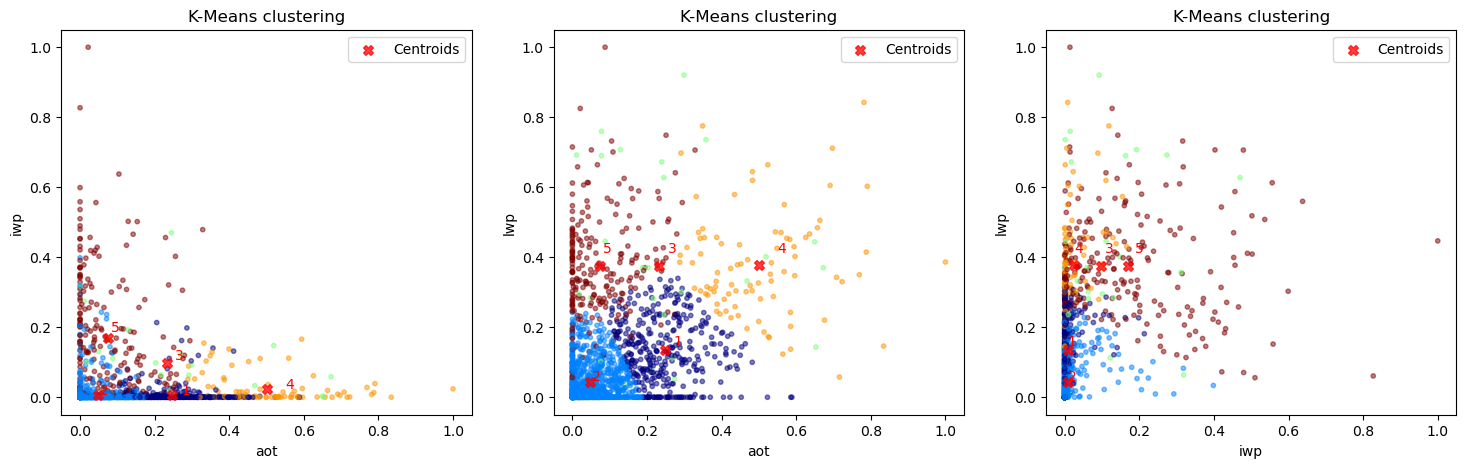

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

varX='aot'
varY='iwp'

plot_kmeans(x, varX, varY, ax=axes[0])

varX='aot'
varY='lwp'

plot_kmeans(x, varX, varY, ax=axes[1])


varX='iwp'
varY='lwp'

plot_kmeans(x, varX, varY, ax=axes[2])

(0.0, 0.25)

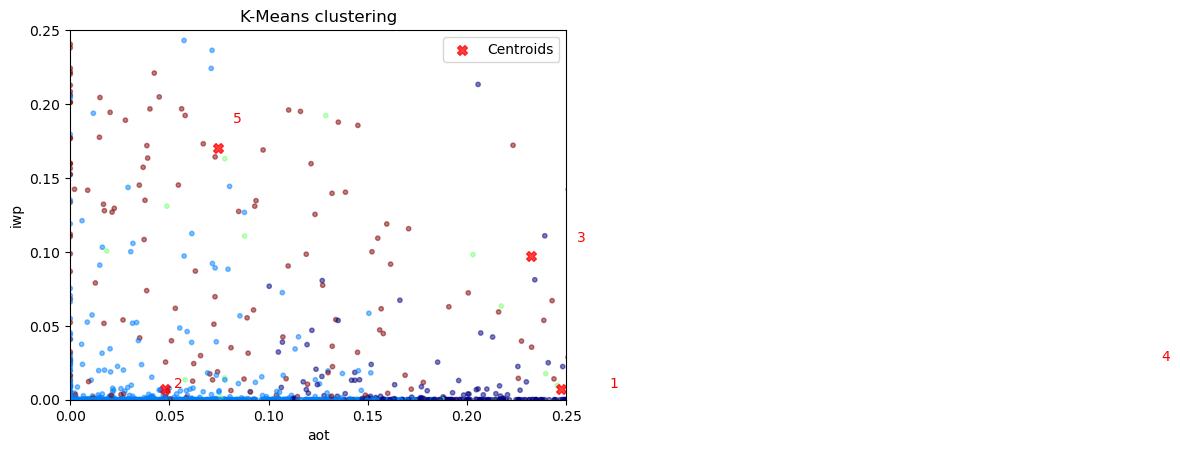

In [16]:
varX='aot'
varY='iwp'

plot_kmeans(x, varX, varY)
plt.xlim(0, 0.25)
plt.ylim(0, 0.25)

### Classes we were expepcting:

- Cluster 4: Aerosol with no clouds

- Cluster 3: Ice and water with no transparency (ATLID is not seeing aerosol)

Let's see the other three


In [17]:
# select only clusters 1, 2 and 5

In [18]:
np.unique(y_kmeans)

array([0, 1, 2, 3, 4], dtype=int32)

In [19]:
indices = np.where((y_kmeans == 0) | (y_kmeans == 1) | (y_kmeans == 4))[0]

In [20]:
(vars['iwp'], vars['aot'])

(1, 3)

In [21]:
a = x[indices, 3]
b = x[indices, 1]

m, q = np.polyfit(a, b, deg=1)

b_pred = q + m * a #+ n *a**2

print(q, m, n)


0.042320595037075144 -0.1009563934295314 20


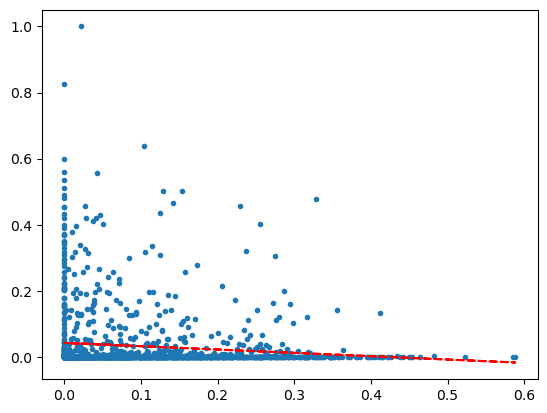

In [22]:
varX='aot'
varY='iwp'

# plot_kmeans(x, varX, varY)
# plt.xlim(0, 0.25)
# plt.ylim(0, 0.25)

plt.plot(a, b, '.')
plt.plot(a, b_pred, 'r--')

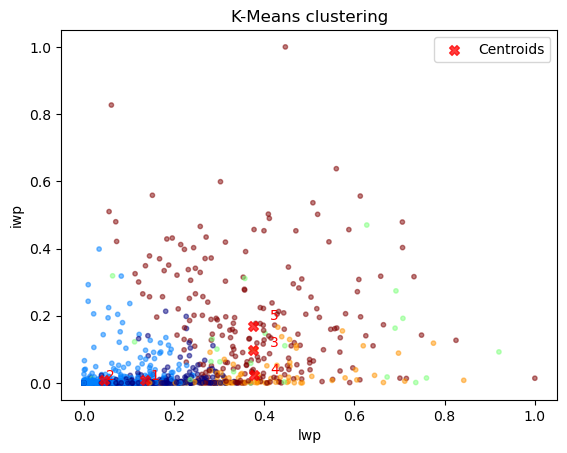

In [23]:
varX='lwp'
varY='iwp'

plot_kmeans(x, varX, varY)

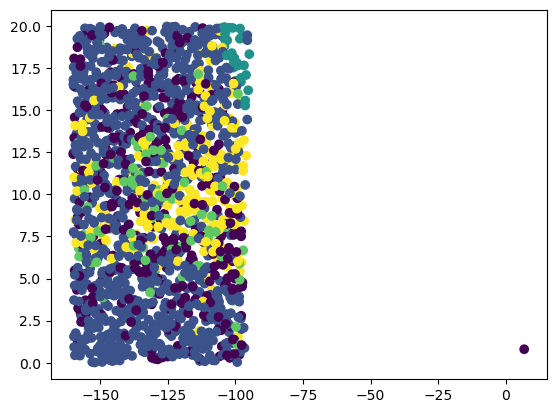

In [24]:
plt.scatter(ds['longitude'].values, ds['latitude'].values, c=y_kmeans, cmap='viridis')

Text(0, 0.5, 'latitude')

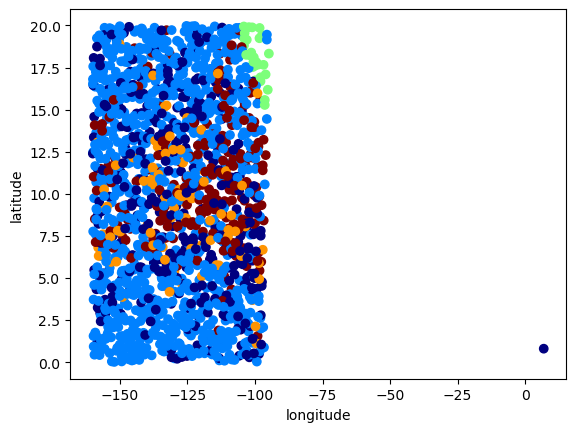

In [25]:
plt.scatter(ds['longitude'].values, ds['latitude'].values, c=y_kmeans, cmap='jet')
plt.xlabel('longitude')
plt.ylabel('latitude')

In [26]:
# TODO Let's see how the AC__TC labels pair up with the clusters